In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest


df = pd.read_csv("../data/breast_cancer_final.csv")  # Update path if needed
df['diagnosis'] = df['diagnosis'].map({'B': 0, 'M': 1})  # Encode target

X = df.drop(columns=["diagnosis"])  # Fix: Removed extra parenthesis
y = df["diagnosis"]

Selected features by RFECV (21):
['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'compactness_se', 'concave points_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst']


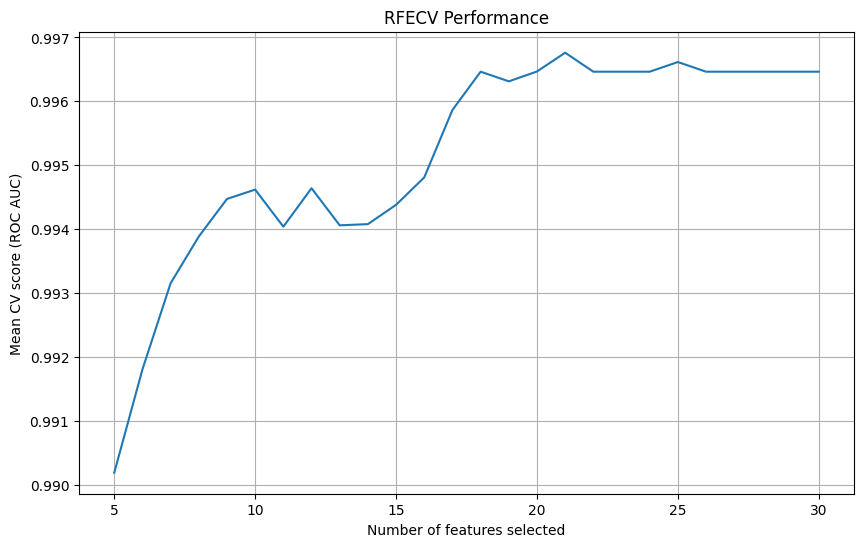

In [ ]:
# Method 1: RFECV
lr = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    max_iter=10000,
    C=1.0,
    l1_ratio=0.0,
    random_state=42
)
rfecv = RFECV(
    estimator=lr,
    cv=StratifiedKFold(5),
    scoring='roc_auc',
    min_features_to_select=5,
    n_jobs=-1
)
rfecv.fit(X, y)
rfecv_features = X.columns[rfecv.support_]

print(f"Selected features by RFECV ({len(rfecv_features)}):")
print(rfecv_features.tolist())

# Plot number of features vs. cross-validation scores
plt.figure(figsize=(10, 6))
plt.plot(
    range(5, len(rfecv.cv_results_['mean_test_score']) + 5),
    rfecv.cv_results_['mean_test_score']
)
plt.xlabel("Number of features selected")
plt.ylabel("Mean CV score (ROC AUC)")
plt.title("RFECV Performance")
plt.grid(True)
plt.show()

Top 10 features by Mutual Information:
['perimeter_worst', 'concave points_mean', 'area_worst', 'concave points_worst', 'radius_worst', 'perimeter_mean', 'concavity_mean', 'radius_mean', 'area_mean', 'concavity_worst']


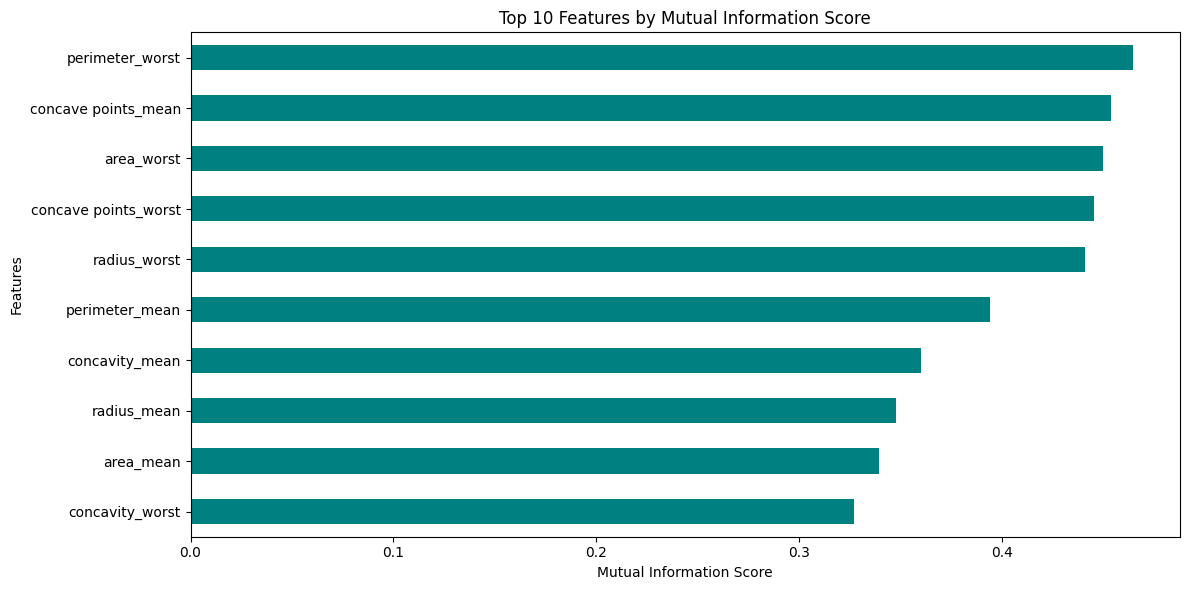

In [6]:
# Method 2:Mutual Information Feature Selection
# Calculate mutual information scores
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_scores = pd.Series(mi_scores, index=X.columns, name="MI Scores")

# Select top k features
k = 10  # Number of top features to select
mi_features = mi_scores.nlargest(k).index.tolist()

print(f"Top {k} features by Mutual Information:")
print(mi_features)

# Plot the mutual information scores
plt.figure(figsize=(12, 6))
mi_scores.nlargest(k).sort_values().plot.barh(color='teal')
plt.title(f"Top {k} Features by Mutual Information Score")
plt.xlabel("Mutual Information Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

### Evaluation with Selected Features

In [8]:
from sklearn.model_selection import cross_val_score

# Function to evaluate model with selected features
def evaluate_features(features, model, X, y, cv=5):
    X_selected = X[features]
    scores = cross_val_score(model, X_selected, y, cv=cv, scoring='roc_auc')
    return np.mean(scores), np.std(scores)

# Full feature set performance
full_mean, full_std = evaluate_features(X.columns, lr, X, y)
print(f"Full features ({len(X.columns)}): AUC = {full_mean:.4f} ± {full_std:.4f}")

# RFECV selected features
rfecv_mean, rfecv_std = evaluate_features(rfecv_features, lr, X, y)
print(f"RFECV features ({len(rfecv_features)}): AUC = {rfecv_mean:.4f} ± {rfecv_std:.4f}")



Full features (30): AUC = 0.9965 ± 0.0049
RFECV features (21): AUC = 0.9974 ± 0.0040
